In [1]:
# Imports
import os
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# https://stackoverflow.com/questions/28816046/
# displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis("off")

    # Display the image.
    ax.imshow(im_data, cmap="gray")

    plt.show()

In [3]:
def area_filter(min_area, input_image):
    # Perform an area filter on the binary blobs:
    (
        components_number,
        labeled_image,
        component_stats,
        componentCentroids,
    ) = cv2.connectedComponentsWithStats(input_image, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    # (skip the background component at index 0)
    remaining_component_labels = [
        i for i in range(1, components_number) if component_stats[i][4] >= min_area
    ]

    # Filter the labeled pixels based on the remaining labels,
    # assign pixel intensity to 255 (uint8) for the remaining pixels
    filteredImage = np.where(
        np.isin(labeled_image, remaining_component_labels) == True, 255, 0
    ).astype("uint8")

    return filteredImage

In [4]:
def preprocess(skewed, imagePath):
    # Read image
    inputImage = cv2.imread(skewed)

    # Conversion to CMYK (just the K channel):
    # Convert to float and divide by 255:
    imgFloat = inputImage.astype(np.float64) / 255.0

    # Calculate channel K:
    kChannel = 1 - np.max(imgFloat, axis=2)

    # Convert back to uint 8:
    kChannel = (255 * kChannel).astype(np.uint8)

    # Threshold image:
    binaryThresh = 130
    _, binaryImage = cv2.threshold(kChannel, binaryThresh, 255, cv2.THRESH_BINARY)

    # Filter small blobs:
    minArea = 100
    binaryImage = area_filter(minArea, binaryImage)

    # Use a little bit of morphology to clean the mask:
    # Set kernel (structuring element) size:
    kernelSize = 3

    # Set morph operation iterations:
    opIterations = 2

    # Get the structuring element:
    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

    # Perform closing:
    binaryImage = cv2.morphologyEx(
        binaryImage,
        cv2.MORPH_CLOSE,
        morphKernel,
        None,
        None,
        opIterations,
        cv2.BORDER_REFLECT101,
    )

    cv2.imwrite(
        "C:\\Users\\User\\Pictures\\samples\\dirty\\thres\\"
        + os.path.basename(imagePath),
        binaryImage,
    )

    # display("my_temp/thres.jpg")

# Rotation or Deskewing

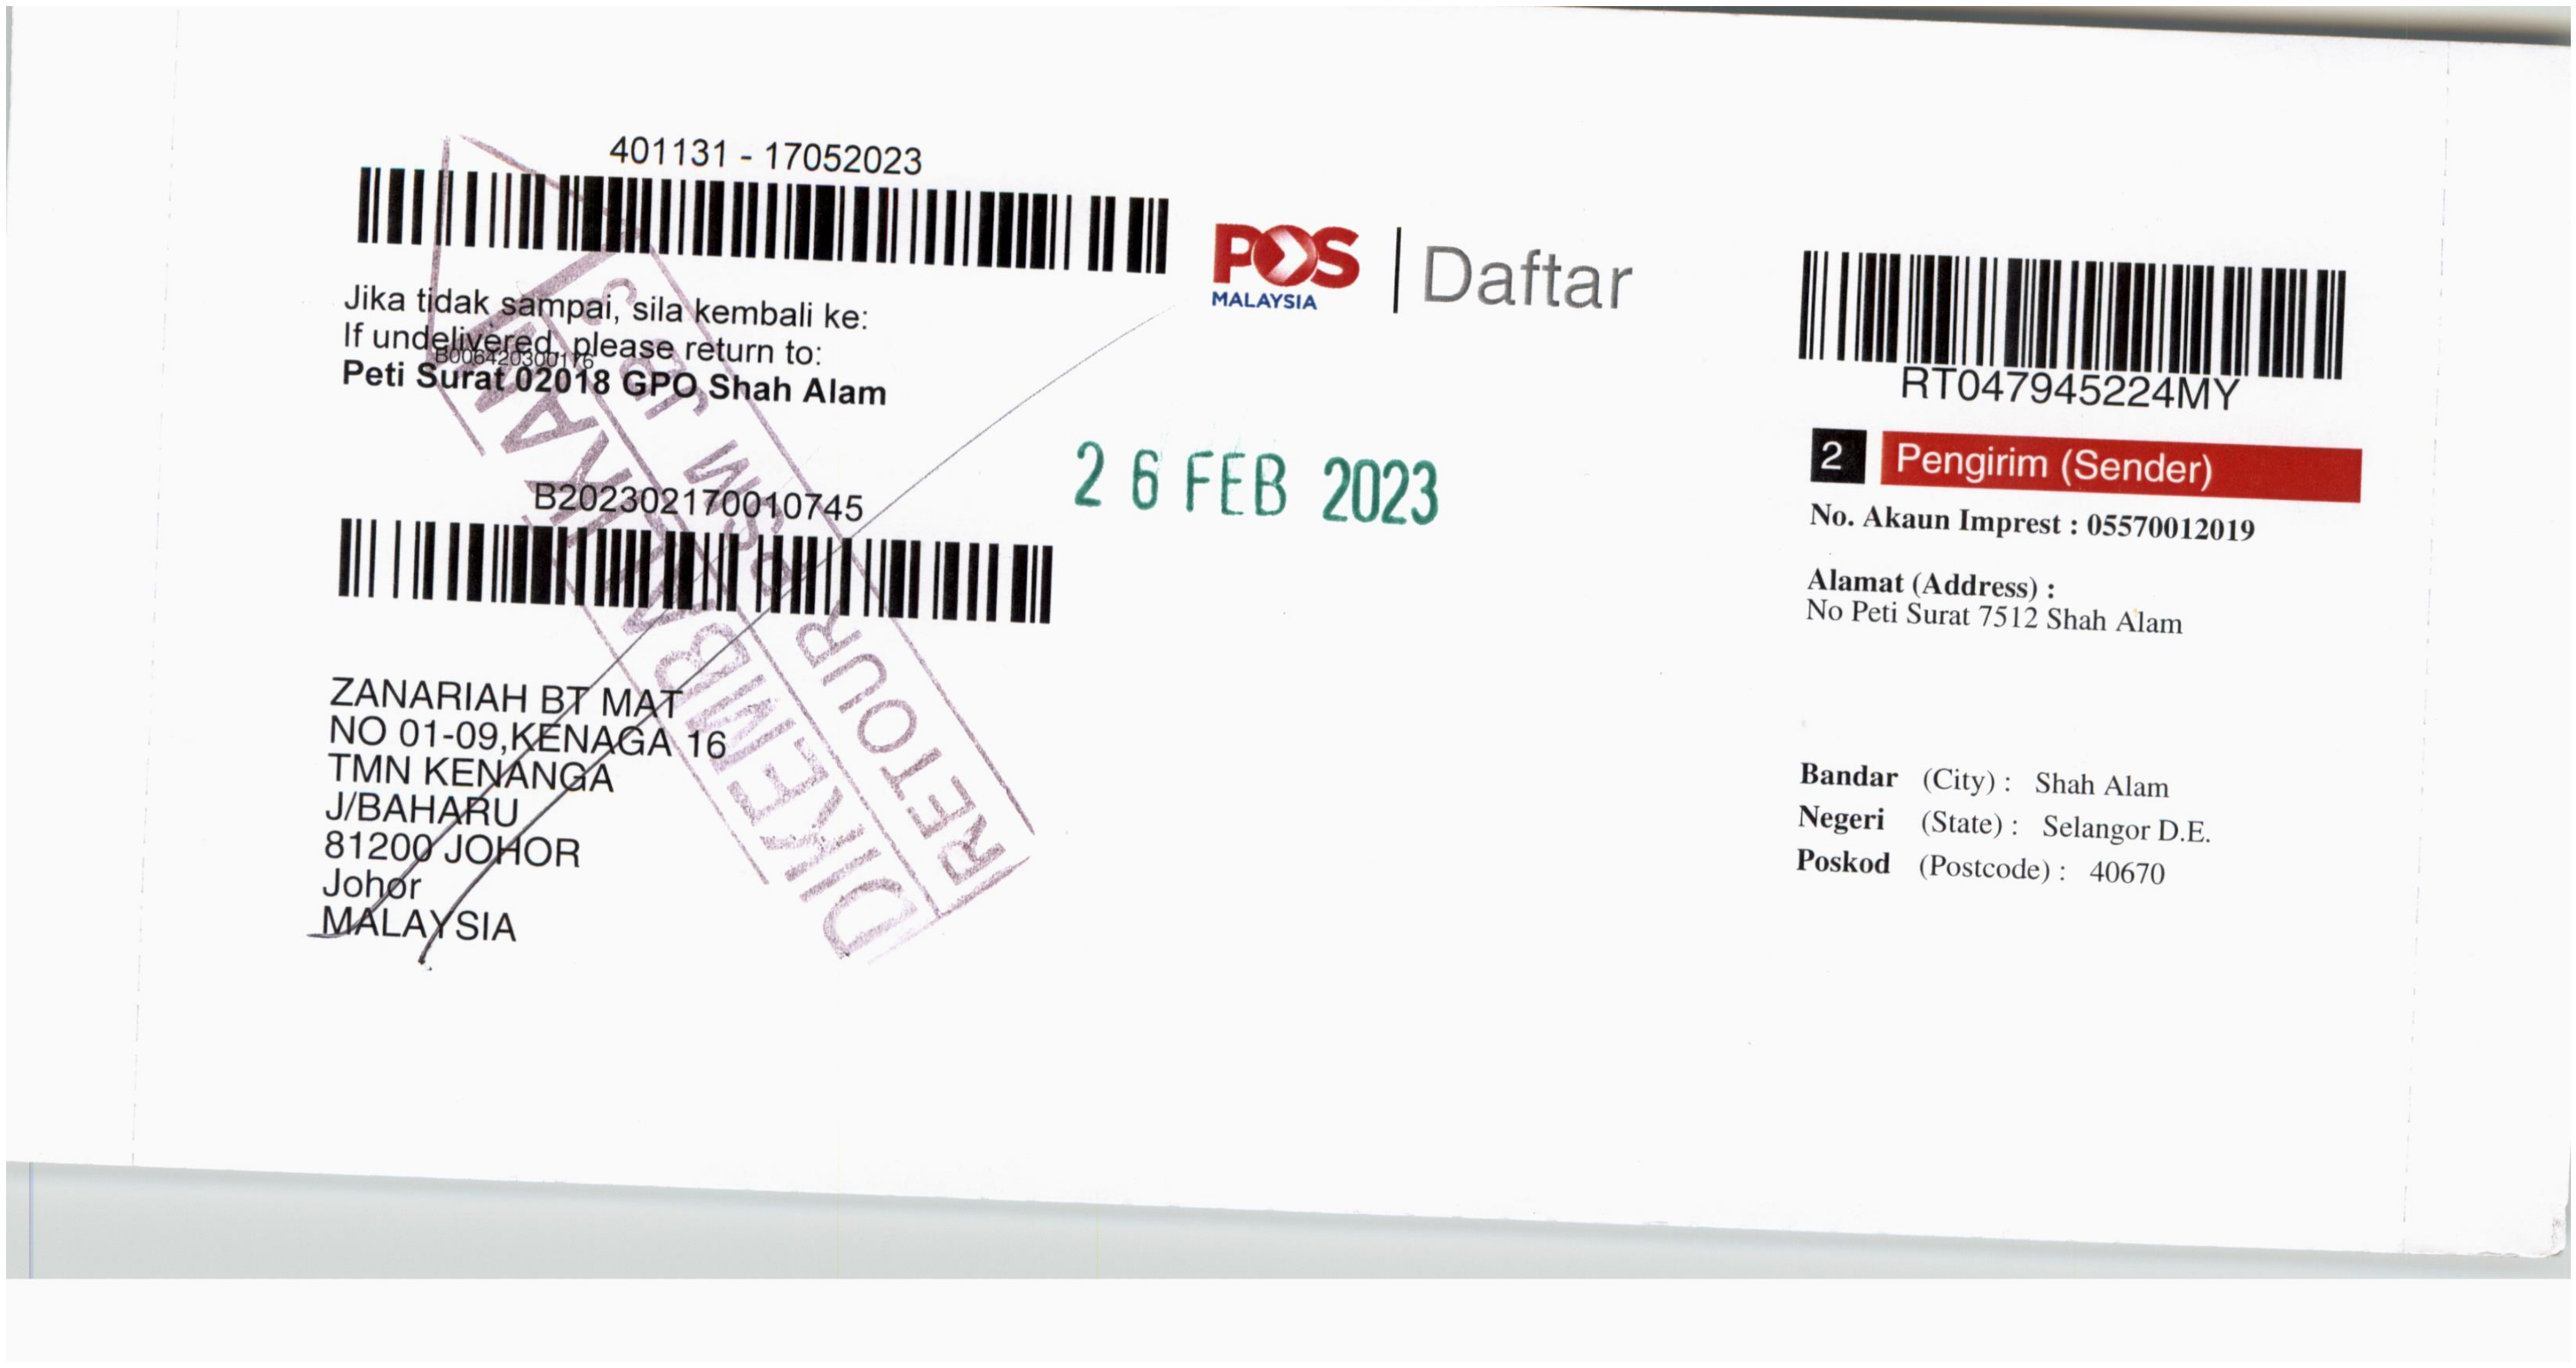

In [5]:
new = cv2.imread("my_data/target_2.jpg")
display("my_data/target_2.jpg")

In [6]:
# https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np


def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(
        dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x, y, w, h = rect
        cv2.rectangle(newImage, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print(len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("my_temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(
        newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    return newImage

In [7]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [8]:
fixed = deskew(new)
cv2.imwrite("my_temp/target_2_fixed.jpg", fixed)

54


True

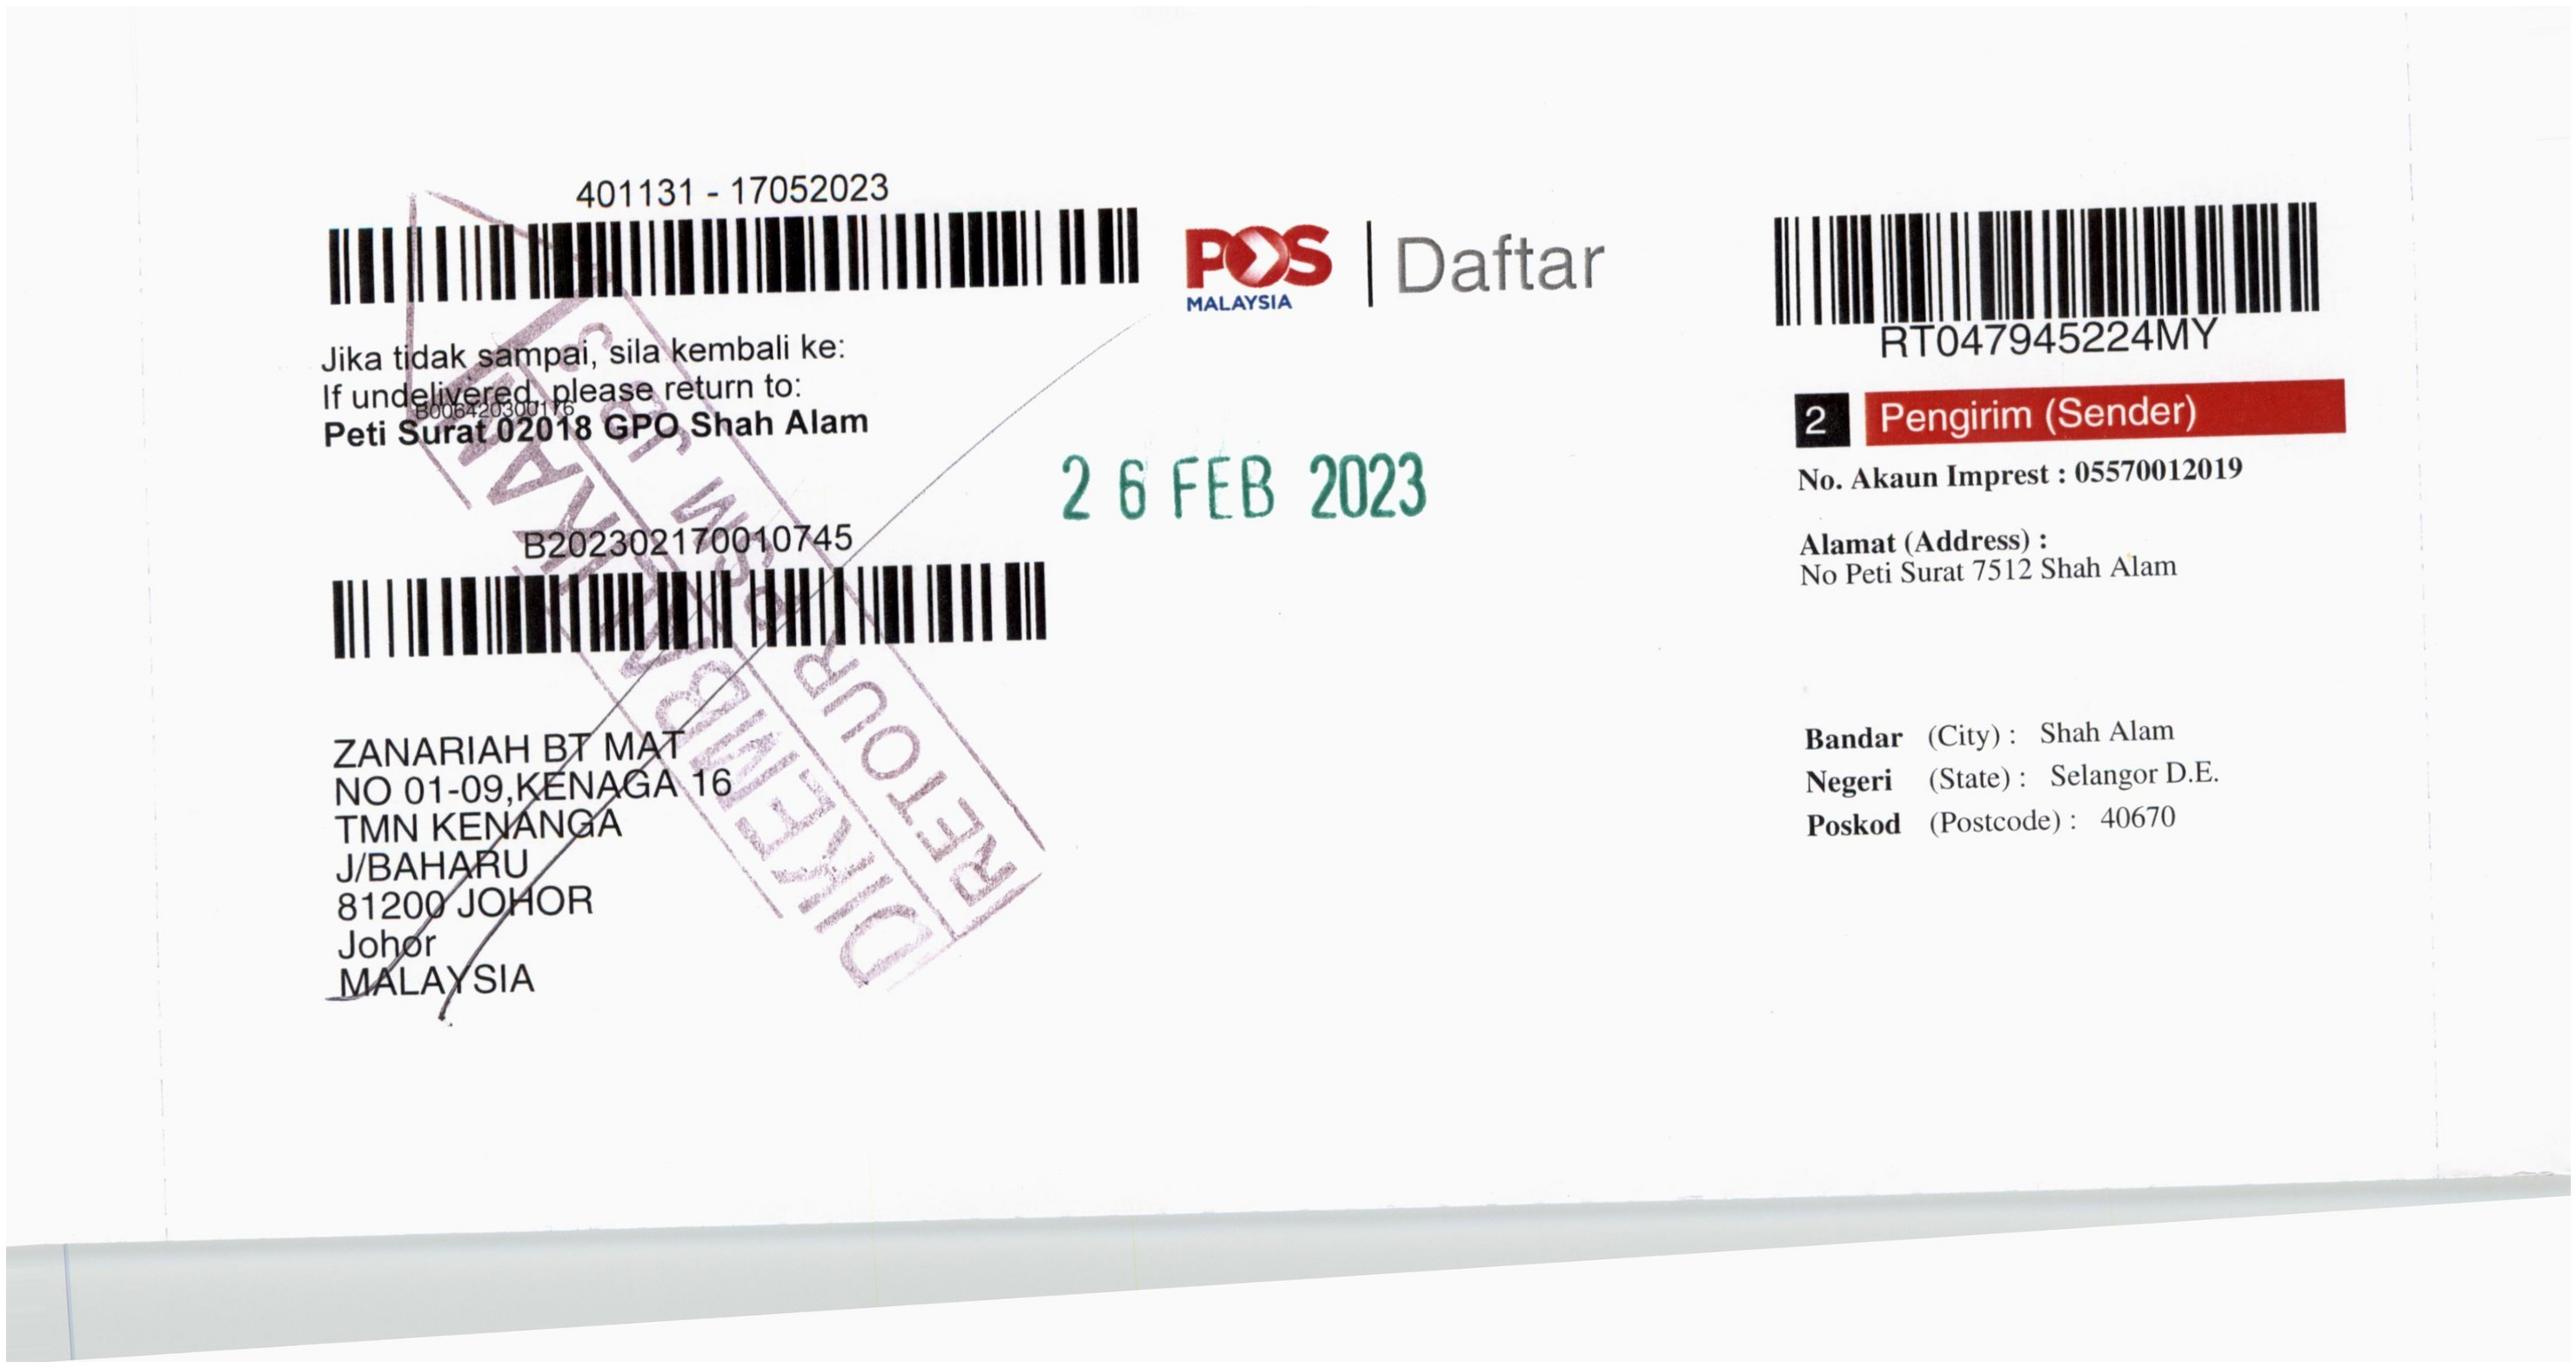

In [9]:
display("my_temp/target_2_fixed.jpg")

# Image Thresholding & Binarization

In [10]:
raw_dir = "C:\\Users\\User\\Pictures\\samples\\dirty\\"
image_files = []
# Use glob to match files with certain extensions (e.g., jpg, png, etc.)
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp']

for ext in image_extensions:
    pattern = os.path.join(raw_dir, ext)
    image_files.extend(glob.glob(pattern))


In [11]:
for image_file in image_files:
    img = cv2.imread(image_file)
    skewed = deskew(img)
    cv2.imwrite("my_temp/thres.jpg", skewed)

    preprocess("my_temp/thres.jpg", image_file)

64
84
28
56
58
55
27
36
175
59
45
58
53
46
42
51
49
54
72
147
72
54
38
57
44
66
39
28
62
47
44
81
56
56
